# Extract and compare DEM elevation with ICESat-2 Points
1. Merge DEMs strips is more than 1
2. Extract Elevation for DEM
3. Note Time and Time difference between acquisition of ICESat-2, DEM imagery, and if DEM composed of cross-track imageries

May 07, 2020  

In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 7), 'font.size': 10})

import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
import geopandas as gpd
import xarray as xr
# import rasterio as rio

import hvplot
import geoviews as gv
import hvplot.pandas
import hvplot.xarray

In [3]:
# Choose Icesat-2 Product
short_name = 'ATL06'

# Setup data paths
region = 'region_06_greenland_northwest'#'region_02_greenland_southeast'
dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:' '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
dem_type = ['REMA', 'EarthDEM', 'ArcticDEM']
dem_type = dem_type[2] # MUST CHOOSE
# Here we will start to ICESat-2 because all of these have corresponding DEM folder
base_icesat2_path = f'/fs/project/howat.4/icesat2/{dem_type}/{region}_{short_name}' # Set the icesat2_path : where ICESat-2 files are staged
strips = os.listdir(base_icesat2_path)
# Select a particular satellite, WV03 for example
# strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

502

In [4]:
# NB: Strips for merging vertically
# strip = strips[-2], ie: 'WV01_20191023_102001008DDFC500_102001008A969D00_2m_lsf_v040101' for region_02_greenland_southeast

In [5]:
# fig_folder = '/home/yadav.111/figs_icesat/ATL06'
analysis_folder = f'/fs/project/howat.4/icesat2/prototyping/analysis/{dem_type}/{region}'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

# strip = 'W1W1_20190416_1020010084CEDB00_1020010085562400_2m_lsf_v030403'
strip = strips[12]
print(strip)
icesat2_path = f'{base_icesat2_path}/{strip}'
files = os.listdir(f'{icesat2_path}')

outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')


hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
csv_files = [f for f in files if f.endswith('.csv') and 'ATL06' in f]

W1W2_20190330_1020010084689400_103001008D7E2800_2m_lsf_v040002


In [6]:
shp_files

['processed_ATL06_20190303015545_09870205_002_01.shp',
 'processed_ATL06_20190307014725_10480205_002_01.shp',
 'processed_ATL06_20190228122752_09480203_002_01.shp',
 'processed_ATL06_20190307014216_10480204_002_01.shp',
 'processed_ATL06_20190228123317_09480204_002_01.shp',
 'processed_ATL06_20190405001815_01030304_002_01.shp',
 'processed_ATL06_20190405002325_01030305_002_01.shp',
 'processed_ATL06_20190401003144_00420305_002_01.shp',
 'processed_ATL06_20190406104712_01250303_002_01.shp',
 'processed_ATL06_20190402105532_00640303_002_01.shp',
 'processed_ATL06_20190429230742_04840305_002_01.shp']

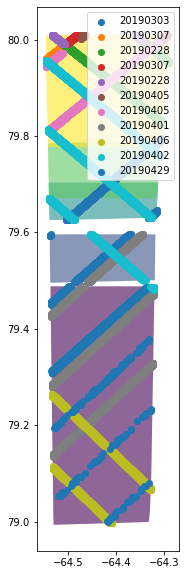

In [7]:
# Quick Check for Data
ax = outline.plot(column='seg_id', alpha=.6, lw=1, figsize=(10,10))
for shp in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{shp}', parse_dates=True)
    lbl = shp.split('_')[2][:8] #pd.to_datetime(shp.split('_')[2][:8])
    gdf.plot(ax=ax, label=lbl)
plt.legend(loc=1);

In [8]:
# Pick the largest granule for quick visualization only
sz_list = [os.path.getsize(f'{icesat2_path}/{hdf}') for hdf in hdf_files]
idx = sz_list.index(max(sz_list)) #largest index
print('No of shp files',len(shp_files), len(hdf_files))
# print(outline.area)

fname = shp_files[idx].split('.shp')[0]

No of shp files 11 11


In [9]:
shp_files

['processed_ATL06_20190303015545_09870205_002_01.shp',
 'processed_ATL06_20190307014725_10480205_002_01.shp',
 'processed_ATL06_20190228122752_09480203_002_01.shp',
 'processed_ATL06_20190307014216_10480204_002_01.shp',
 'processed_ATL06_20190228123317_09480204_002_01.shp',
 'processed_ATL06_20190405001815_01030304_002_01.shp',
 'processed_ATL06_20190405002325_01030305_002_01.shp',
 'processed_ATL06_20190401003144_00420305_002_01.shp',
 'processed_ATL06_20190406104712_01250303_002_01.shp',
 'processed_ATL06_20190402105532_00640303_002_01.shp',
 'processed_ATL06_20190429230742_04840305_002_01.shp']

## Choose a corresponding DEM Strip for Analysis

Some metadata info about DEMs and Orthos
https://www.pgc.umn.edu/guides/arcticdem/data-description/#section-3  
_matchtag.tif – Bitmask raster indicating DEM pixels derived from a stereo match (1) or those that have been interpolated (0)
0 edge 1 1
1 water 1 0
2 cloud 1 0


In [10]:
outline#.name.values[0]#==outline.name.values[1]

name           time1  \
0  W1W2_20190330_1020010084689400_103001008D7E280...  20190330214500   
1  W1W2_20190330_1020010084689400_103001008D7E280...  20190330214459   
2  W1W2_20190330_1020010084689400_103001008D7E280...  20190330214458   
3  W1W2_20190330_1020010084689400_103001008D7E280...  20190330214457   
4  W1W2_20190330_1020010084689400_103001008D7E280...  20190330214454   

            time2  seg_id                                           geometry  
0  20190331203837       1  POLYGON ((-64.53218 79.16696, -64.53604 79.483...  
1  20190331203836       2  POLYGON ((-64.31971 79.50085, -64.32033 79.500...  
2  20190331203835       3  POLYGON ((-64.53968 79.70055, -64.53950 79.702...  
3  20190331203835       4  POLYGON ((-64.30706 79.78863, -64.31395 79.678...  
4  20190331203833       5  POLYGON ((-64.52103 80.00942, -64.41990 80.009...

In [11]:
# Load ATL parsed data
fname = 'processed_ATL06_20190402105532_00640303_002_01'#'processed_ATL06_20190303015545_09870205_002_01' # choose file overwriting previous choice
df = pd.read_csv(f'{icesat2_path}/{fname}.csv', parse_dates=True)
gdf = gpd.read_file(f'{icesat2_path}/{fname}.shp', parse_dates=True)
# Pick only the good quality data [verify if zero or one means good]
df = df[df.q_flag==0]
gdf = gdf[gdf.q_flag==0]
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
#Also reset index
gtls = list(df.strip.unique())
print(len(df), gtls)
# gv.tile_sources.ESRI * gdf.hvplot.points(geo=True, color='strip', alpha=0.7, width=500, height=700, hover=['strip', 'h_te_media'])

4664 ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']


In [12]:
base = gv.tile_sources.ESRI
gtracks = gdf.hvplot.points(geo=True, color='strip', s=10, alpha=0.7, width=500, height=600)
terrain_scatter = df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters').relabel('Elevation') # by='strip', 
dem_outline = outline.hvplot(geo=True, color='seg_id', alpha=.4)
fig1 = base * dem_outline * gtracks + terrain_scatter
# hvplot.save(fig1, f'{analysis_folder}/test.png') #not working newly due to path for firefox or chromium
fig1

:Layout
   .Overlay.I           :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .Polygons.I :Polygons   [Longitude,Latitude]   (seg_id)
      .Points.I   :Points   [Longitude,Latitude]   (strip)
   .NdOverlay.Elevation :NdOverlay   [strip]
      :Scatter   [h_li]   (lat)

In [13]:
# To Pick the DEM segment with most overlap IC02
# outline.crs, gdf.crs
# outline.hvplot(geo=True, color='seg_id', alpha=.4)

In [84]:
# outline.cx[:, :2]
from earthpy import clip as cl

In [90]:
# Clip the icesat2 points that fall within the lake shapefile
clip_files = []
outside_files = []
for fname in shp_files:
    try:
        gdf = gpd.read_file(f'{icesat2_path}/{fname}')
        clip = cl.clip_shp(gdf, outline)
        #clip.to_file(f'{icesat2_path}/clips/{fname}')
        clip_files.append(fname)
        print(f'{fname}: {len(clip)}')
    except ValueError:
        # ValueError: Shape and crop extent do not overlap.
        outside_files.append(fname)

processed_ATL06_20190303015545_09870205_002_01.shp: 5540
processed_ATL06_20190307014725_10480205_002_01.shp: 371
processed_ATL06_20190228122752_09480203_002_01.shp: 2331
processed_ATL06_20190307014216_10480204_002_01.shp: 205
processed_ATL06_20190228123317_09480204_002_01.shp: 368
processed_ATL06_20190405001815_01030304_002_01.shp: 147
processed_ATL06_20190405002325_01030305_002_01.shp: 2268
processed_ATL06_20190401003144_00420305_002_01.shp: 6100
processed_ATL06_20190406104712_01250303_002_01.shp: 3536
processed_ATL06_20190402105532_00640303_002_01.shp: 5702
processed_ATL06_20190429230742_04840305_002_01.shp: 283


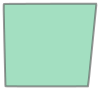

In [99]:
row[1]['geometry']

In [116]:
# For a whole DEM outline, what is the intersection with specific icesat gt 
for fname in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{fname}')
    print(f'{fname}: {len(gdf)}')
    for row in outline.iterrows():
        try:
            clip = cl.clip_shp(gdf, gpd.GeoSeries(row[1]['geometry']))
            print(f'\t{row[0]}: {len(clip)}')
        except:
            #print(f'No Overlap {row[0]}')
            pass

processed_ATL06_20190303015545_09870205_002_01.shp: 5540
	0: 2435
	1: 1137
	2: 1012
	3: 1292
	4: 141
processed_ATL06_20190307014725_10480205_002_01.shp: 371
	4: 371
processed_ATL06_20190228122752_09480203_002_01.shp: 2331
	4: 2331
processed_ATL06_20190307014216_10480204_002_01.shp: 205
	4: 205
processed_ATL06_20190228123317_09480204_002_01.shp: 368
	4: 368
processed_ATL06_20190405001815_01030304_002_01.shp: 147
	4: 147
processed_ATL06_20190405002325_01030305_002_01.shp: 2268
	4: 2268
processed_ATL06_20190401003144_00420305_002_01.shp: 6100
	0: 5058
	1: 1042
processed_ATL06_20190406104712_01250303_002_01.shp: 3536
	0: 3536
processed_ATL06_20190402105532_00640303_002_01.shp: 5702
	0: 59
	1: 1080
	2: 1320
	3: 1582
	4: 2227
processed_ATL06_20190429230742_04840305_002_01.shp: 283
	0: 283


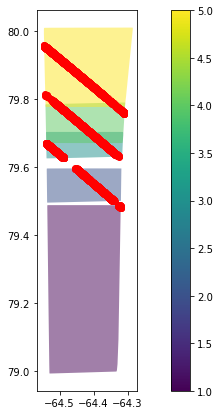

In [14]:
# gpd.GeoSeries(row[1]['geometry'])
ax = outline.plot(column='seg_id', alpha=.5, legend=True)
gdf.plot(ax=ax, c='r')

In [ ]:
# Clip the icesat2 points that fall within the lake shapefile
clip_files = []
outside_files = []
for fname in shp_files:
    try:
        gdf = gpd.read_file(f'{icesat2_path}/{fname}')
        clip = cl.clip_shp(gdf, outline)
        #clip.to_file(f'{icesat2_path}/clips/{fname}')
        clip_files.append(fname)
        print(f'{fname}: {len(clip)}')
    except ValueError:
        # ValueError: Shape and crop extent do not overlap.
        outside_files.append(fname)

In [15]:
# Some dems has gaps in between segments, eg: /fs/byo/howat-data5/ArcticDEM/region_02_greenland_southeast/strips_v4/2m/W1W2_20190428_102001008466F300_1030010090702200_2m_lsf_v040002
# so icesat-2 will has gaps as well; to make it contineous 

In [16]:
# df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters', subplots=True)

In [15]:
strip

'W1W2_20190330_1020010084689400_103001008D7E2800_2m_lsf_v040002'

In [16]:
dem_folder = f'{dir_prefix}/{dem_type}/{region}/strips_v4/2m/{strip}'

In [17]:
# What is the time difference between Icesat and DEM
time_diff = pd.to_datetime(fname.split('_')[2]) - pd.to_datetime(strip.split('_')[1])
print(time_diff)

3 days 10:55:32


In [18]:
# If there is more than one DEM, find a way to merge them into one seamless DEM
segments = [tif.split('_')[-2] for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
segments.sort() #This is inplace sorting
print(len(segments))
segments

5


['seg1', 'seg2', 'seg3', 'seg4', 'seg5']

In [19]:
# dem_tif = [tif.split('_seg')[0] for tif in os.listdir(dem_folder)] # if tif.endswith('_dem.tif')

In [20]:
# Get full base path for all DEMs and Orthos and Matchtags
# Pick a segment : one or more
seg = segments[4]
dem_prefix = '_'.join(strip.split('_')[:-1])
dem_prefix = f'{dem_folder}/{dem_prefix}_{seg}'

dem = f'{dem_prefix}_dem.tif'
print(dem)
matchtag = f'{dem_prefix}_matchtag.tif'
bitmask = f'{dem_prefix}_bitmask.tif'
ortho = f'{dem_prefix}_ortho.tif'
os.path.exists(dem), os.path.exists(matchtag), os.path.exists(bitmask), os.path.exists(ortho)

/fs/byo/howat-data5/ArcticDEM/region_06_greenland_northwest/strips_v4/2m/W1W2_20190330_1020010084689400_103001008D7E2800_2m_lsf_v040002/W1W2_20190330_1020010084689400_103001008D7E2800_2m_lsf_seg5_dem.tif


(True, True, True, True)

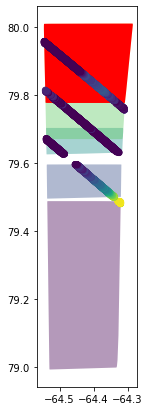

In [21]:
# Overview of how ground-tracks intersect with DEM outline
ax = outline.plot(column='seg_id', alpha=.4)
outline[outline.seg_id==int(seg.strip('seg'))].plot(ax=ax, color='r')

gdf.plot(ax=ax, column='h_li');

## Use Xarray load and analyze DEM

In [22]:
dem = xr.open_rasterio(dem) #, chunks={'x':2**11, 'y':2**11}
dem = dem.load()
# da = xr.open_rasterio(f'{dem_folder}/{ortho_tif}')

In [23]:
nodata_value = dem.attrs['nodatavals'][0]
dem.data[dem.data==nodata_value] = np.nan # dem.datareplace no-data with NANs
print(nodata_value)

-9999.0


In [24]:
# dem.sel(band=1).plot.imshow(cmap='viridis', robust=True);

In [25]:
# matchtag = xr.open_rasterio(matchtag)
bitmask = xr.open_rasterio(bitmask)

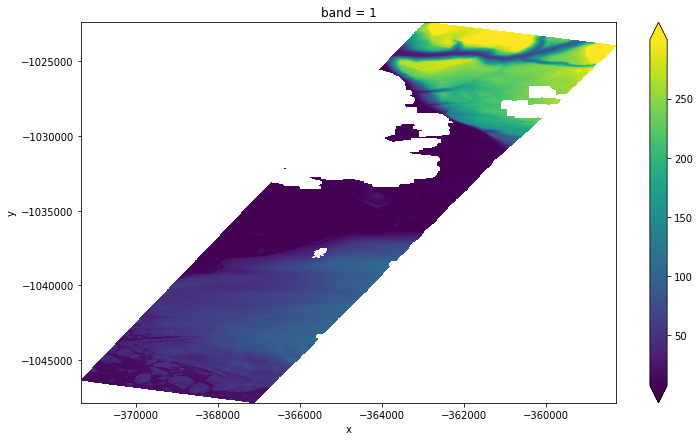

In [26]:
# Mask out problematic DEM values based matchtag mask [remove value = 0 or keep value == 1]; ie, put NANs whereever matchtag NOT == 1
# dem = dem.where(matchtag.data==1)
dem = dem.where(bitmask.data==0)
# matchtag.sel(band=1).plot.imshow();
dem.sel(band=1).plot.imshow(cmap='viridis', robust=True);

In [27]:
# bitmask.sel(band=1).plot.imshow(robust=True);

In [28]:
# Change Icesat shapefile projection to match DEM's projection
# Else can't extract elevation from DEM
# Required to overlay plots as well
proj4 = dem.crs #dem.projection.ExportToProj4() # but there is extra space at the end
gdf1 = gdf.to_crs(proj4) 
# gdf1.iloc[1].geometry.x, gdf1.iloc[1].geometry.y

In [29]:
len(gdf1)

4664

## Extraction pixel value from raster for each point

In [30]:
def getPixVal(pt):
    """ Given a Geopandas/Shapely Point geometry, extract the pixel value from the Xarray raster """
    #x, y = pt.coords[:][0]
    out = dem.sel(x = pt.x, y=pt.y, method='nearest')
    return out.values[0]

In [31]:
gdf1['dem'] = gdf1.geometry.apply(getPixVal)

In [32]:
nan_count = len(gdf1[np.isnan(gdf1.dem)])
print(nan_count)
print('Nans Fraction: ', nan_count/len(gdf1))

3457
Nans Fraction:  0.7412092624356775


In [33]:
gdf1 = gdf1.dropna() #Drop the Nans from the edges of DEM
gdf1['dif'] = gdf1.h_li - gdf1.dem
gdf1 = gdf1.drop(['t_dt', 'q_flag'], axis=1)

In [34]:
len(gdf1), len(gdf)

(1207, 4664)

In [35]:
gdf1.strip.value_counts()

gt3l    535
gt3r    512
gt2r     87
gt2l     73
Name: strip, dtype: int64

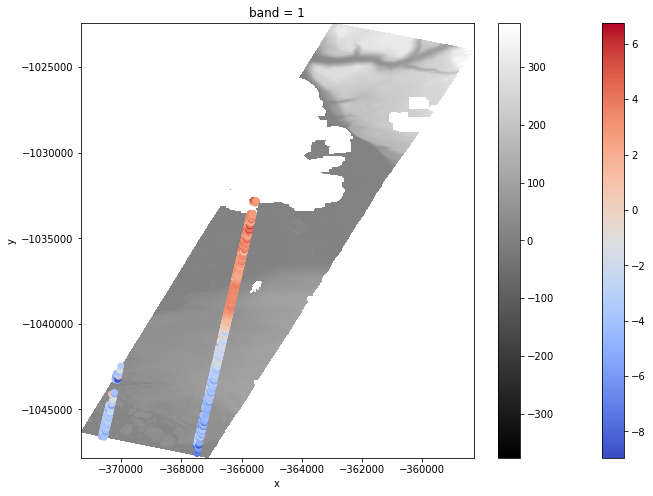

In [36]:
# da.plot.imshow(cmap='gist_earth')
ax = gdf1.plot(column='dif', cmap='coolwarm', legend=True, figsize=(11, 8))
# ax = gdf1.plot(column='dif', legend=True, figsize=(11, 8))
dem.sel(band=1).plot.imshow(ax=ax, cmap='gray');

In [37]:
gdf1.tail(2)

h_li strip                          geometry       dem       dif
4400  11.029090  gt3r  POINT (-365524.783 -1032816.493)  7.564560  3.464530
4401  11.033699  gt3r  POINT (-365522.212 -1032797.108)  8.391818  2.641881

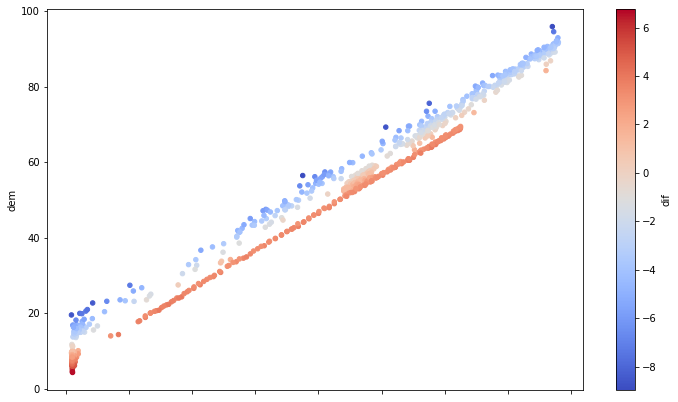

In [58]:
gdf1[['h_li','dem', 'dif']].plot(kind='scatter', x=0, y=1, c='dif', cmap='coolwarm');

In [64]:
# df.hvplot(y='lat', x='h_li', kind='scatter', width=350, height=600, by='strip', s=5, alpha=.9, xlabel='meters', subplots=True)

In [59]:
# gdf1[['h_li','dem']].hvplot(kind='scatter', x=0, y=1);
gdf1[['h_li','dem', 'strip']].hvplot(y='dem', x='h_li', kind='scatter', by='strip', subplots=False)

:NdOverlay   [strip]
   :Scatter   [h_li]   (dem)

In [40]:
gdf1[gdf1.strip=='gt3r'][['h_li','dem']].hvplot(kind='scatter', alpha=.5)

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

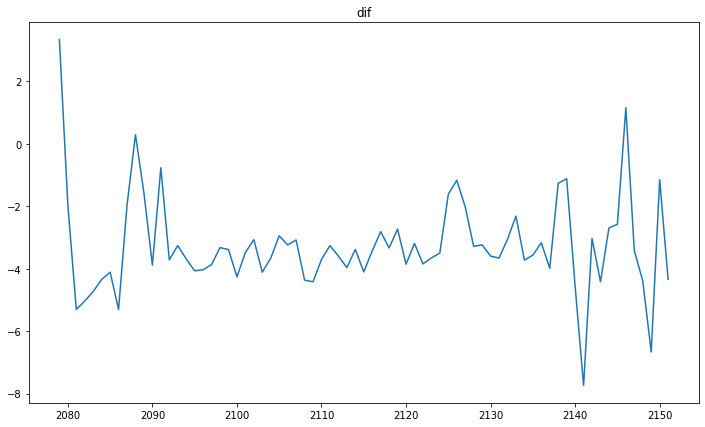

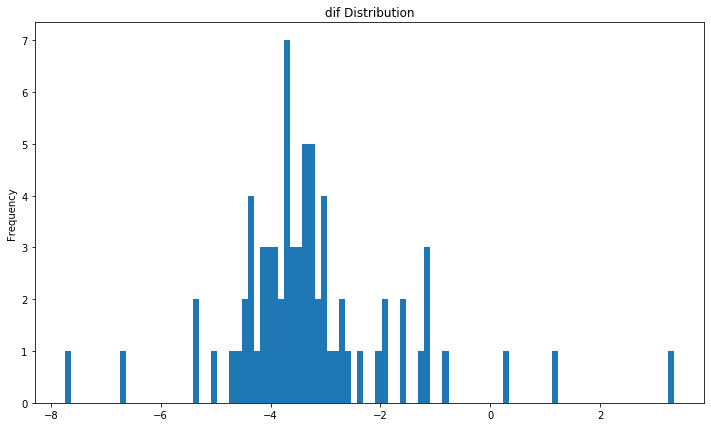

In [41]:
gdf1[gdf1.strip=='gt2l'].dif.plot(title='dif')
plt.figure()
gdf1[gdf1.strip=='gt2l'].dif.plot(kind='hist', bins=100, title='dif Distribution');

In [42]:
# ortho_tif
ortho = xr.open_rasterio(ortho)#.load()
# nodata_value = ortho.attrs['nodatavals'][0]
# # First conver to fload, so it can be converted to nan
# ortho.data = ortho.data.astype(float)

# ortho.data[ortho.data==nodata_value] = np.nan
# print(nodata_value)

In [43]:
np.nanmax(ortho.data)

1742

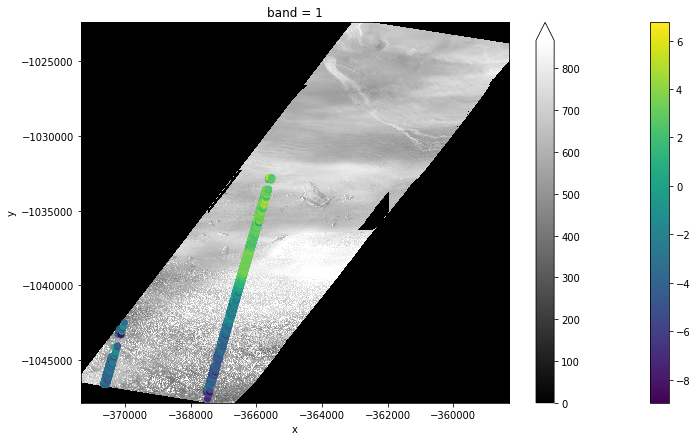

In [44]:
ax = gdf1.plot(column='dif', legend=True)
ortho.sel(band=1).plot.imshow(ax=ax, robust=True, cmap='gray'); #, cmap='gist_earth'

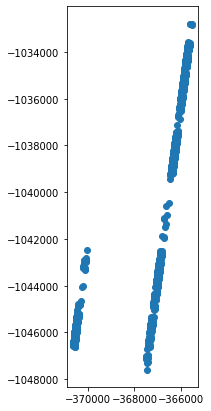

In [45]:
gdf1[np.abs(gdf1.dif)>3].plot();

In [46]:
# gdf2 = gdf1.reset_index(drop = True)

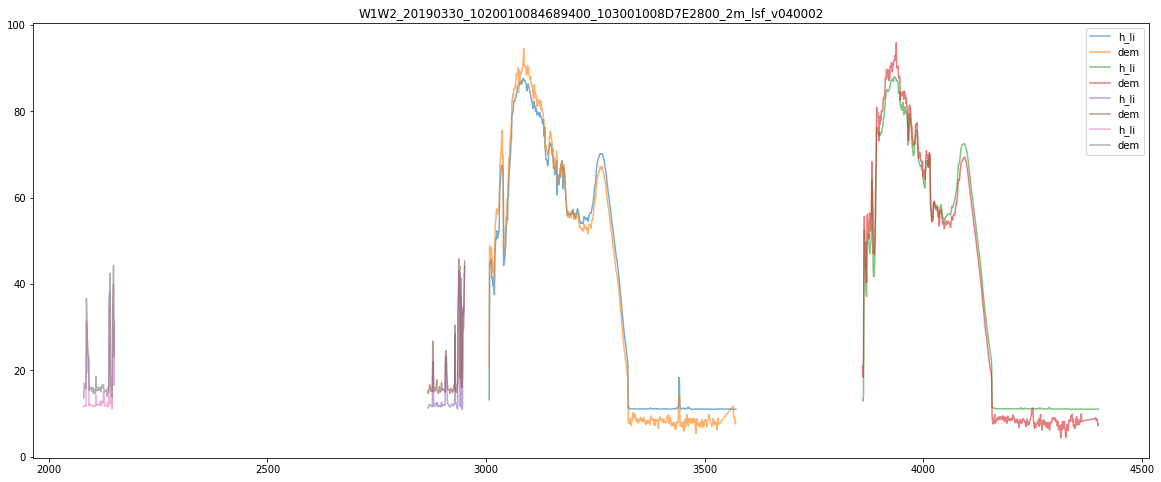

In [47]:
gtls = list(gdf1.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# gtl = gtls[2]
fig, ax = plt.subplots(figsize=(20, 8))
for gtl in gtls:
    gdf1[gdf1.strip==gtl][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax);

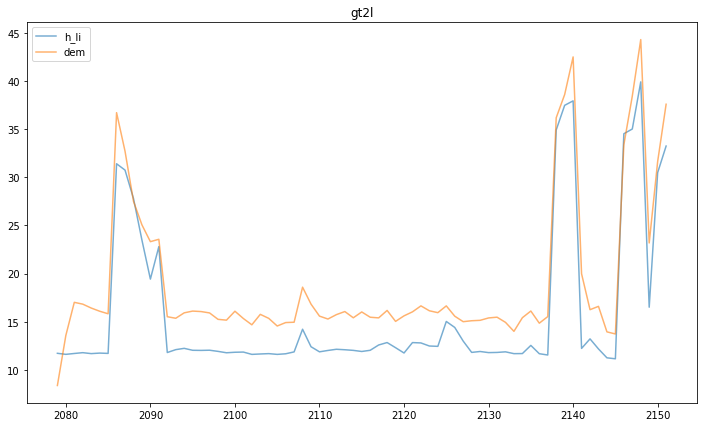

In [48]:
gdf1[gdf1.strip==gtl][['h_li', 'dem']].plot(style='-', alpha=.6, title=gtl);

In [50]:
# gdf1[gdf1.strip==gtl].reset_index()[['h_li', 'dem']].plot(style='-', alpha=.6, title=gtl);

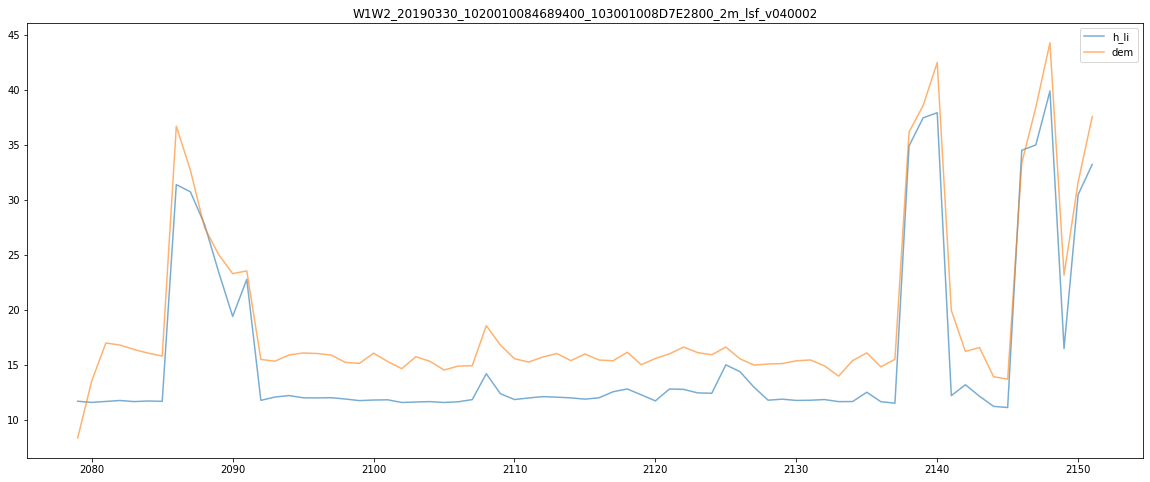

In [51]:
# gdf[['h_li', 'dem']].plot()
fig, ax = plt.subplots(figsize=(20, 8))
# gdf2[gdf2.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf1[gdf1.strip==gtls[3]][['h_li', 'dem']].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

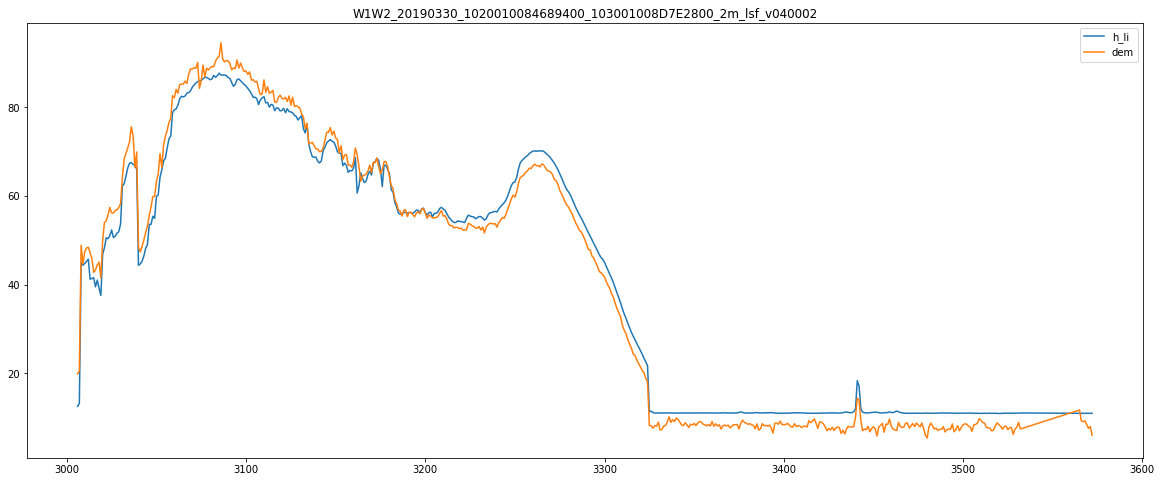

In [52]:
fig, ax = plt.subplots(figsize=(20, 8))
# gdf1[gdf1.strip==gtls[0]][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', title=strip, ax=ax); #, ax=ax
gdf1[gdf1.strip==gtls[0]][['h_li', 'dem']].plot(style='-', title=strip, ax=ax); #, ax=ax

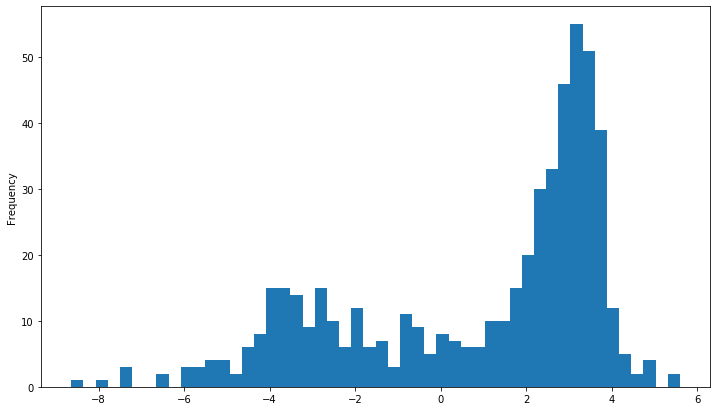

In [53]:
gdf1[gdf1.strip==gtls[0]].dif.plot(kind='hist', bins=50);

In [54]:
time_diff

Timedelta('3 days 10:55:32')

In [55]:
fname

'processed_ATL06_20190402105532_00640303_002_01'

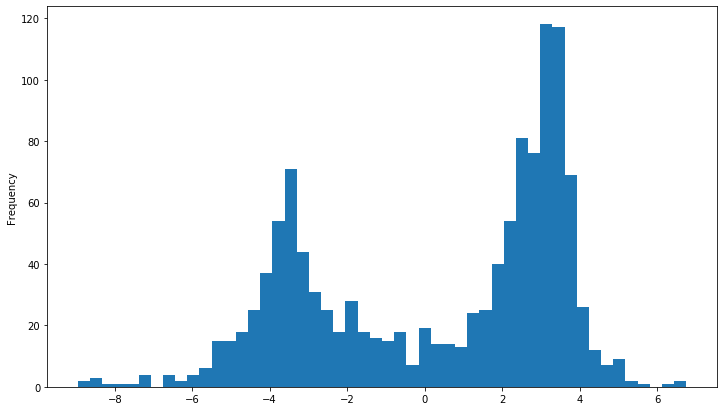

In [56]:
gdf1.dif.plot(kind='hist', bins=50);

In [82]:
gdf1.dif.mean()

4.311683122208669

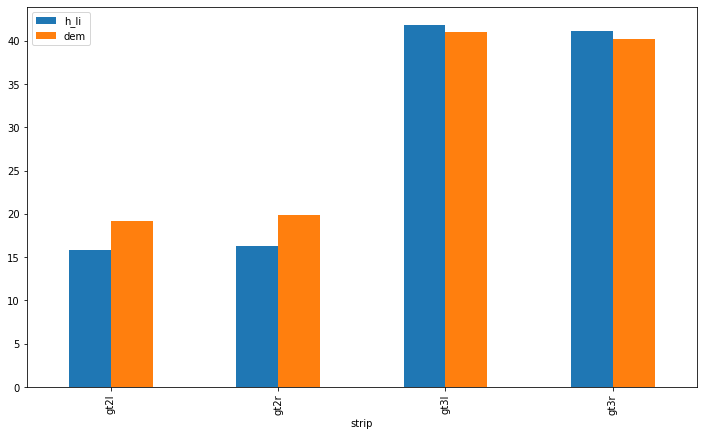

In [57]:
dfg = gdf1.groupby('strip')
# dfg.dif.mean().plot(kind='bar');
dfg[['h_li', 'dem']].mean().plot(kind='bar');

In [84]:
# gtl = 'gt2'
# ax = gdf1[gdf1.strip==f'{gtl}l'][['dem','h_li']].plot(lw=4, alpha=.5)
# gdf2[gdf2.strip==f'{gtl}r'][['h_li', 'dem']].plot(ax = ax)